In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
# 2. Read the CSV file and assign the 'Price' column to the variable df1
df = pd.read_csv('/Users/baoan/Desktop/STB-His-torical-Data-19.csv')
df1 = df.reset_index()['Price']
df

,Date,Price,Open,High,Low,Vol.,Change %
0,05/19/2017,12400.0,12450.0,12550.0,12350.0,2.61M,-0.40%
1,05/22/2017,12700.0,12400.0,12900.0,12350.0,5.15M,2.42%
2,05/23/2017,12400.0,12800.0,12900.0,12400.0,3.42M,-2.36%
3,05/24/2017,12550.0,12500.0,12750.0,12400.0,2.94M,1.21%
4,05/25/2017,12400.0,12550.0,12750.0,12350.0,4.88M,-1.20%
...,...,...,...,...,...,...,...
1495,05/15/2023,27000.0,27000.0,27600.0,26900.0,29.85M,0.75%
1496,05/16/2023,27400.0,27000.0,27550.0,27000.0,13.15M,1.48%
1497,05/17/2023,27000.0,27400.0,27500.0,26900.0,17.69M,-1.46%
1498,05/18/2023,27200.0,27150.0,27500.0,27000.0,15.19M,0.74%


In [4]:
# Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [5]:
# Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [6]:
# Hàm Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [7]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [8]:
n_features = 90
X_train = X_train[:, :n_features]
X_val = X_val[:, :n_features]
X_test = X_test[:, :n_features]

In [9]:
# Define GBT Model
model = GradientBoostingRegressor()

In [10]:
# Fit mô hình với dữ liệu train
model.fit(X_train, y_train)

GradientBoostingRegressor()

In [11]:
# Dự báo dữ liệu test, val
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

In [12]:
ytest = scaler.inverse_transform(y_test.reshape(-1,1))
yval = scaler.inverse_transform(y_val.reshape(-1,1))

In [13]:
# Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 25739.505582900594
Testing RMSE: 27243.169097827224


In [14]:
# Đánh giá độ chính xác thuật toán bằng MAPE
valid_mape = np.mean(np.abs(y_pred_val - y_val)/np.abs(y_pred_val))
test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_pred))

print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation MAPE: 0.1589669167666192
Testing MAPE: 0.22862213606563364


In [15]:
from sklearn.metrics import mean_absolute_error
# mae = mean_absolute_error(actual_prices, predicted_prices)
valid_mae = mean_absolute_error(yval, y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation MAE: 25728.82154356313
Testing MAE: 26763.777224883437


In [16]:
# Dự báo 30 ngày tiếp theo
x_input = val_data[60:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
i = 0
while i < 30:
    if len(temp_input) > 90:
        x_input = np.array(temp_input[1:]).reshape(1, -1)
        yhat = model.predict(x_input)
        temp_input.extend(yhat.tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        yhat = model.predict(x_input)
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        i += 1

In [17]:
# Reshape lst_output to (n_samples, 1)
lst_output = np.array(lst_output).reshape(-1, 1)

# Inverse transform lst_output
predicted_values = scaler.inverse_transform(lst_output)

In [18]:
# Lấy giá trị dự báo cho 30 ngày tiếp theo
predicted_values = predicted_values.flatten()  # Chuyển về mảng 1D
next_30_days = predicted_values[-30:]  # Lấy 30 ngày cuối cùng

# In ra dự báo cho 30 ngày tiếp theo
for i, value in enumerate(next_30_days, 1):
    print(f"Day {i}: {value}")

Day 1: 30179.771311127046
Day 2: 30179.771311127046
Day 3: 30179.771311127046
Day 4: 30179.771311127046
Day 5: 30179.771311127046
Day 6: 30179.771311127046
Day 7: 30179.771311127046
Day 8: 30179.771311127046
Day 9: 30179.771311127046
Day 10: 30179.771311127046
Day 11: 30179.771311127046
Day 12: 30179.771311127046
Day 13: 30179.771311127046
Day 14: 30179.771311127046
Day 15: 30179.771311127046
Day 16: 30179.771311127046
Day 17: 30179.771311127046
Day 18: 30179.771311127046
Day 19: 30179.771311127046
Day 20: 30179.771311127046
Day 21: 30179.771311127046
Day 22: 30179.771311127046
Day 23: 30179.771311127046
Day 24: 30086.299511737005
Day 25: 30086.299511737005
Day 26: 30086.299511737005
Day 27: 30086.299511737005
Day 28: 30086.299511737005
Day 29: 30086.299511737005
Day 30: 30086.299511737005


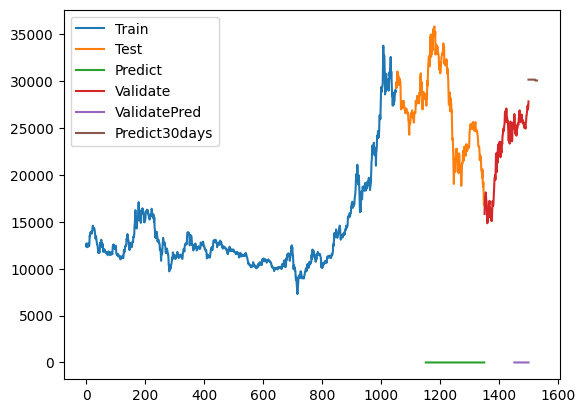

In [19]:
# Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

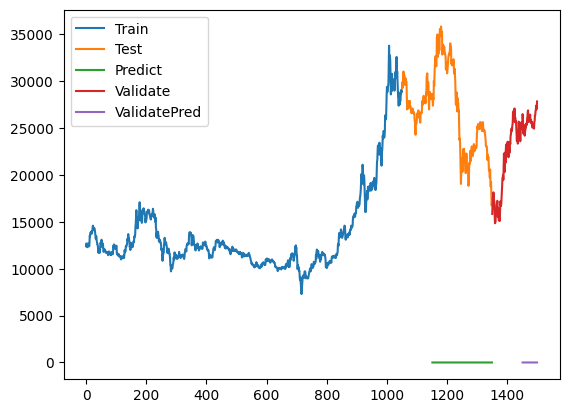

In [20]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

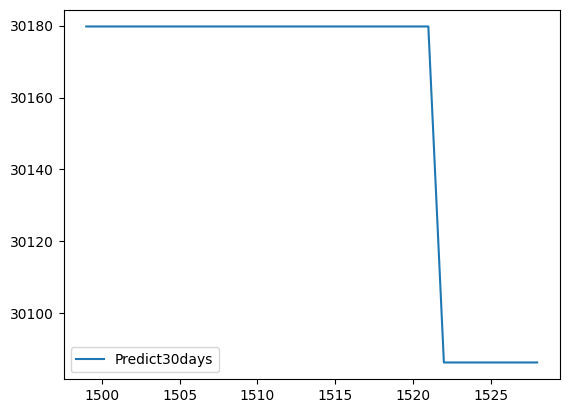

In [21]:
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Predict30days'])
plt.show()